In [4]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import time
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from aux_functions import angle_to_2d,is_accurate, plot_metrics, draw_gaze360_arrow
from datasets_utils import MPIIFaceGaze,Gaze360Dataset
from random import randint
from torch.nn import MSELoss

In [6]:
from transformers import TrainingArguments, Trainer
from typing import Optional, Union, Tuple
from dataclasses import dataclass
from transformers.modeling_outputs import ModelOutput
from transformers.models.mobilevit.modeling_mobilevit import (
    MobileViTPreTrainedModel,
    MobileViTModel,
    MobileViTConfig,
)

# Tarea

- Predecir el ángulo de la mirada a partir de fotografías de caras.
- Datasets: 
    - Gaze360
    - MPIIFaceGaze. [Link here](https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation).
    

# 0. Configuración

CUDA

In [7]:
# CUDA configurations
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [8]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Device: cuda


# 1. Análisis de datos

> Nota: Los datasets deben ubicarse bajo la carpeta ./dataset

## 1.1. Estructura de los datos - cantidad de imágenes

In [9]:
import scipy.io
# Read dataset and get data
data = scipy.io.loadmat("./datasets/Gaze360/metadata.mat")
recording = data['recording'][0]
print(f"Hay {len(recording)} imagenes")

Hay 197588 imagenes


In [10]:
# Se crea una clase propia para facilitar la carga del dataset
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=4000,random=True,yaw_limits=[-1.1,1.1])

In [12]:
gaze_list = []
for data in ds:
    gaze = data["labels"]
    gaze_list.append(gaze)

## 1.2. Distribuciónde los datos


Los ángulos se representan mediante coordenadas polares, mediante los valores pitch y yaw. Para más inforación ver la siguiente imagen:

![head_ref.png](head_ref.png)

Vamos a analizar la distribución de datos de:

- Pitch: Movimiento vertical.
- Yaw: Movimiento horizontal.
- Angle_2d: Ángulo "plano", proyectado en 2 dimensiones

In [9]:
gaze_array = np.array(gaze_list)
pitch_array = gaze_array[:,1]
yaw_array = gaze_array[:,0]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

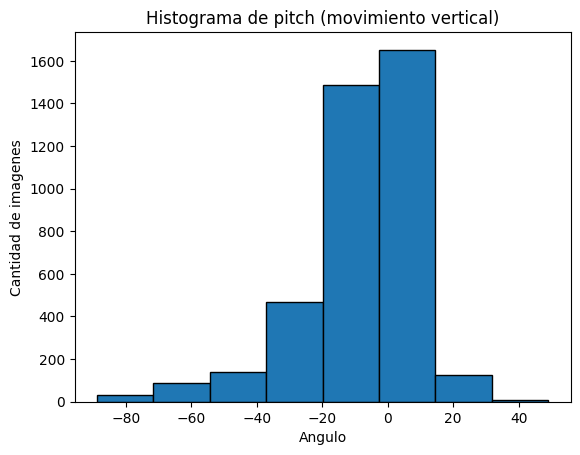

In [10]:
pitch_array_deg = np.rad2deg(pitch_array)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cantidad de imagenes')
plt.title('Histograma de pitch (movimiento vertical)')
plt.show()

### 1.2.2 Yaw

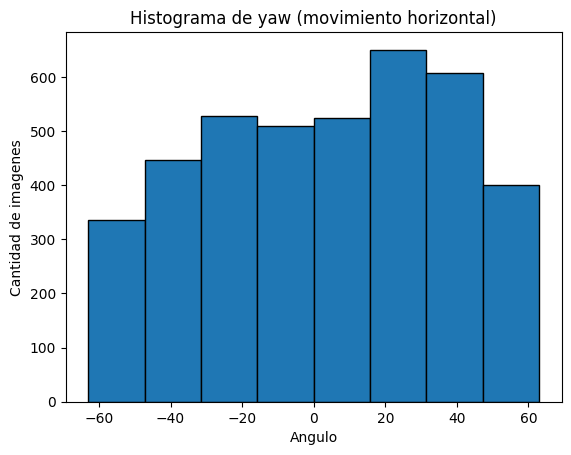

In [11]:
yaw_array_deg = np.rad2deg(yaw_array)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cantidad de imagenes')
plt.title('Histograma de yaw (movimiento horizontal)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

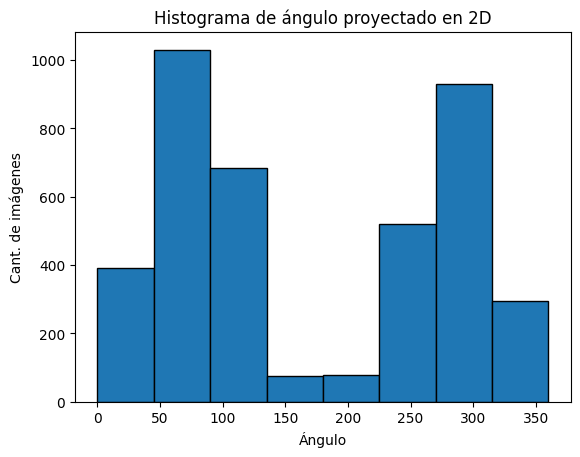

In [12]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Polar plot de pitch y yaw

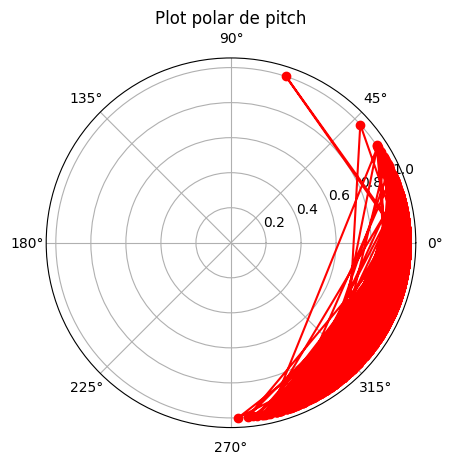

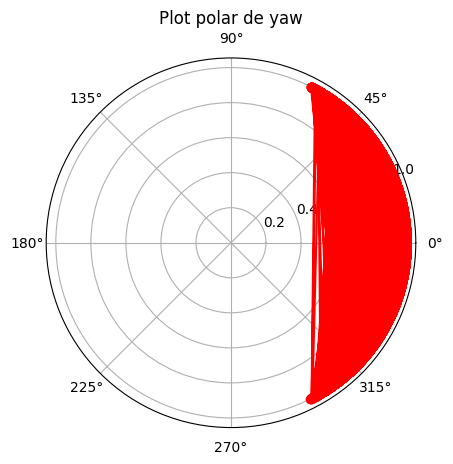

In [14]:
magnitude_array = np.ones_like(pitch_array)

# Pitch
plt.polar(pitch_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de pitch')
# Show the plot
plt.show()

# Yaw
plt.polar(yaw_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de yaw')
# Show the plot
plt.show()

### 1.2.5 Distribution conjunta



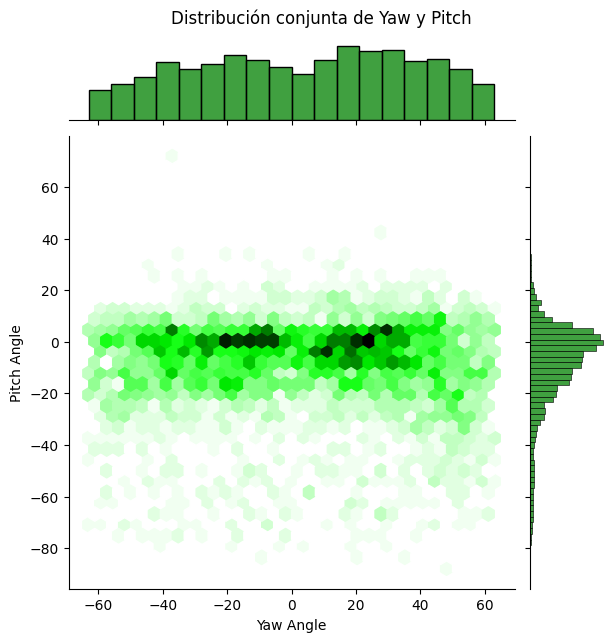

In [17]:
import seaborn as sns

sns.jointplot(x=yaw_array_deg, y=pitch_array_deg, kind="hex", color="g")
plt.xlabel('Yaw Angle')
plt.ylabel('Pitch Angle')
plt.suptitle('Distribución conjunta de Yaw y Pitch', y=1.03)
plt.show()

# 2. Preparación del dataset

## 2.1 Data augmentation

- Se hace un resize de las imágenes a 224x224 para usar MobileViT pre-entrenado en ImageNet
- Data augmentation:
    - RandomResizedCrop: Recorta y hace zoom en las imágenes de manera aleatoria.
    - ColorJitter: Cambia la saturación y el tono de las imágenes, ligeramente.
    - HorizontalFlip o VerticalFlip: no se pueden usar porque altera el ángulo de la mirada.

In [64]:
WIDTH = 224 
HEIGHT = 224

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.1,1.5)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    # torchvision.transforms.RandomErasing(p=0.1,scale=(0.02,0.08),ratio=(1,1.7),value="random"),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    # torchvision.transforms.Normalize(mean=[0.2740, 0.2626, 0.2639],std=[0.1757, 0.1787, 0.1761]),
])


In [65]:
# Ahora sí cargamos todas las imágenes que se van a utilizar en el entrenamiento
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=2000,random=True,transform=data_transforms,yaw_limits=[-1.1,1.1])
print(f"Se cargaron {len(ds)} imágenes")

Se cargaron 2000 imágenes


## 2.2 Datasets de train y test

In [66]:
# (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)


In [67]:
torch.cuda.empty_cache()

Shapes: torch.Size([3, 224, 224]) torch.Size([2])
pitch yaw: tensor([ 0.5897, -0.2277])
Pixel_values tensor([0.4708, 0.4713, 0.4727, 0.4739, 0.4728])
Labels: tensor([ 0.5897, -0.2277])


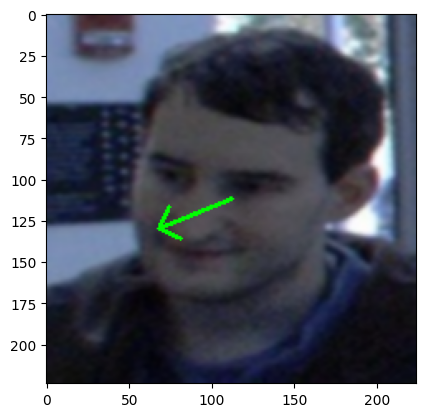

In [68]:
# Visualize a sample
ii =3
train_image = ds[ii]["pixel_values"]
train_labels = ds[ii]["labels"]

print("Shapes:",train_image.shape, train_labels.shape)

# Plot with annotations over it
img = train_image
# img = inverse_normalize(img,mean=torch.tensor([0.2740, 0.2626, 0.2639]),std=torch.tensor([0.1757, 0.1787, 0.1761]))
img = img.permute(1, 2, 0)
img = (img.numpy()*255).astype(np.uint8)
lbl = train_labels
height,width,_ = img.shape
img_annotated = draw_gaze360_arrow(img,lbl,[int(width/2),int(height/2)],scale=80)
plt.imshow(img_annotated)
print(f'pitch yaw: {lbl}')
print("Pixel_values",train_image[0,0,:5])
print("Labels:",train_labels)

# 3. Modelos

Se experimentará con:

- MobileViT
- Algún otro ViT???

## Modelo MobileViT:

- Se cambia la última capa por una capa lineal con dos salidas [yaw,pitch].
- Se utiliza la misma estructura que el modelo de la librería "transformers", para compatibilidad con Trainer y otras funciones de huggingface
- Se crea una dataclass propia para la salida



In [69]:
@dataclass
class ImageRegressionOutput(ModelOutput):
    """
    Custom output for the regression model. 
    """
    loss: Optional[torch.FloatTensor] = None
    predictions: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None


class MobileViTForImageRegression(MobileViTPreTrainedModel):
    def __init__(self, config: MobileViTConfig) -> None:
        super().__init__(config)

        self.mobilevit = MobileViTModel(config)

        # Regression head
        self.dropout = nn.Dropout(config.classifier_dropout_prob, inplace=True)
        self.regressor = nn.Linear(config.neck_hidden_sizes[-1], 2)  # Output [pitch, yaw]

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageRegressionOutput]:
        r"""
        Args:
            pixel_values (`torch.Tensor` of shape `(batch_size, num_channels, height, width)`):
                Pixel values for the images.
            output_hidden_states (`bool`, *optional*):
                Whether to return the hidden states.
            labels (`torch.FloatTensor` of shape `(batch_size, 2)`, *optional*):
                Labels for regression loss calculation. Should contain values `[pitch, yaw]`.
            return_dict (`bool`, *optional*):
                Whether to return the output as a dictionary or a tuple.
        
        Returns:
            `ImageRegressionOutput` or `tuple`:
                The output contains predictions, loss (if labels are provided), and optionally hidden states.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.mobilevit(
            pixel_values=pixel_values,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs.pooler_output if return_dict else outputs[1]
        predictions = self.regressor(self.dropout(pooled_output))

        loss = None
        if labels is not None:
            # print("pixel_values",pixel_values[:,0,0,:5])
            # print("labels",labels)
            loss_fct = MSELoss()
            loss = loss_fct(predictions, labels)

        if not return_dict:
            output = (predictions,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return ImageRegressionOutput(
            loss=loss,
            predictions=predictions,
            hidden_states=outputs.hidden_states,
        )

# Step 1: Define the configuration
config = MobileViTConfig.from_pretrained(
    "apple/mobilevit-small",  # Use the pre-trained MobileViT-small model
)
config.num_labels = 2  # For regression output, we set num_labels to 2 (pitch and yaw)
config.classifier_dropout_prob = 0.0  # Optional: set dropout probability for the regression head

# Step 2: Initialize the MobileViTForImageRegression model
model = MobileViTForImageRegression(config)


In [70]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    num_train_epochs=18,
    weight_decay=0.005,
    logging_dir="./logs",
    logging_steps=1,
    load_best_model_at_end=True,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [71]:
# Train and evaluate
trainer.train()
trainer.evaluate()

  0%|          | 0/5040 [00:00<?, ?it/s]

{'loss': 0.256, 'grad_norm': 18.35713768005371, 'learning_rate': 9.998015873015874e-05, 'epoch': 0.0}
{'loss': 0.2956, 'grad_norm': 18.82672691345215, 'learning_rate': 9.996031746031746e-05, 'epoch': 0.01}
{'loss': 0.2134, 'grad_norm': 19.743825912475586, 'learning_rate': 9.994047619047619e-05, 'epoch': 0.01}
{'loss': 0.4191, 'grad_norm': 28.598264694213867, 'learning_rate': 9.992063492063493e-05, 'epoch': 0.01}
{'loss': 0.2707, 'grad_norm': 22.328380584716797, 'learning_rate': 9.990079365079366e-05, 'epoch': 0.02}
{'loss': 0.1898, 'grad_norm': 15.851958274841309, 'learning_rate': 9.988095238095238e-05, 'epoch': 0.02}
{'loss': 0.284, 'grad_norm': 12.800834655761719, 'learning_rate': 9.986111111111111e-05, 'epoch': 0.03}
{'loss': 0.1354, 'grad_norm': 12.879598617553711, 'learning_rate': 9.984126984126985e-05, 'epoch': 0.03}
{'loss': 0.2951, 'grad_norm': 17.535066604614258, 'learning_rate': 9.982142857142858e-05, 'epoch': 0.03}
{'loss': 0.3309, 'grad_norm': 23.909868240356445, 'learning_

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.2349151074886322, 'eval_runtime': 41.5919, 'eval_samples_per_second': 14.426, 'eval_steps_per_second': 2.885, 'epoch': 1.0}
{'loss': 0.1097, 'grad_norm': 3.0692648887634277, 'learning_rate': 9.442460317460318e-05, 'epoch': 1.0}
{'loss': 0.2943, 'grad_norm': 6.215510845184326, 'learning_rate': 9.440476190476191e-05, 'epoch': 1.01}
{'loss': 0.0505, 'grad_norm': 3.2125461101531982, 'learning_rate': 9.438492063492064e-05, 'epoch': 1.01}
{'loss': 0.2156, 'grad_norm': 4.185213088989258, 'learning_rate': 9.436507936507936e-05, 'epoch': 1.01}
{'loss': 0.1952, 'grad_norm': 4.225574493408203, 'learning_rate': 9.43452380952381e-05, 'epoch': 1.02}
{'loss': 0.2395, 'grad_norm': 4.119781970977783, 'learning_rate': 9.432539682539683e-05, 'epoch': 1.02}
{'loss': 0.2013, 'grad_norm': 4.203352928161621, 'learning_rate': 9.430555555555555e-05, 'epoch': 1.02}
{'loss': 0.3352, 'grad_norm': 6.846932411193848, 'learning_rate': 9.428571428571429e-05, 'epoch': 1.03}
{'loss': 0.4001, 'grad_norm'

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.2321452796459198, 'eval_runtime': 40.2408, 'eval_samples_per_second': 14.91, 'eval_steps_per_second': 2.982, 'epoch': 2.0}
{'loss': 0.2563, 'grad_norm': 6.405547142028809, 'learning_rate': 8.886904761904761e-05, 'epoch': 2.0}
{'loss': 0.1435, 'grad_norm': 2.828019380569458, 'learning_rate': 8.884920634920635e-05, 'epoch': 2.01}
{'loss': 0.3223, 'grad_norm': 3.2167608737945557, 'learning_rate': 8.882936507936508e-05, 'epoch': 2.01}
{'loss': 0.3439, 'grad_norm': 3.7406039237976074, 'learning_rate': 8.880952380952381e-05, 'epoch': 2.01}
{'loss': 0.1511, 'grad_norm': 2.7663278579711914, 'learning_rate': 8.878968253968253e-05, 'epoch': 2.02}
{'loss': 0.2015, 'grad_norm': 5.211940765380859, 'learning_rate': 8.876984126984127e-05, 'epoch': 2.02}
{'loss': 0.3113, 'grad_norm': 2.589203357696533, 'learning_rate': 8.875e-05, 'epoch': 2.02}
{'loss': 0.1794, 'grad_norm': 4.655889511108398, 'learning_rate': 8.873015873015874e-05, 'epoch': 2.03}
{'loss': 0.1685, 'grad_norm': 2.4270505

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.22197774052619934, 'eval_runtime': 42.0213, 'eval_samples_per_second': 14.278, 'eval_steps_per_second': 2.856, 'epoch': 3.0}
{'loss': 0.1174, 'grad_norm': 3.320486307144165, 'learning_rate': 8.331349206349208e-05, 'epoch': 3.0}
{'loss': 0.1972, 'grad_norm': 4.22878885269165, 'learning_rate': 8.32936507936508e-05, 'epoch': 3.01}
{'loss': 0.4006, 'grad_norm': 5.298900604248047, 'learning_rate': 8.327380952380953e-05, 'epoch': 3.01}
{'loss': 0.1354, 'grad_norm': 5.912221431732178, 'learning_rate': 8.325396825396827e-05, 'epoch': 3.01}
{'loss': 0.0979, 'grad_norm': 3.301254987716675, 'learning_rate': 8.323412698412699e-05, 'epoch': 3.02}
{'loss': 0.0943, 'grad_norm': 3.1041033267974854, 'learning_rate': 8.321428571428572e-05, 'epoch': 3.02}
{'loss': 0.1259, 'grad_norm': 2.477962017059326, 'learning_rate': 8.319444444444445e-05, 'epoch': 3.02}
{'loss': 0.1679, 'grad_norm': 2.0366177558898926, 'learning_rate': 8.317460317460319e-05, 'epoch': 3.03}
{'loss': 0.0629, 'grad_norm'

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.16163545846939087, 'eval_runtime': 46.0185, 'eval_samples_per_second': 13.038, 'eval_steps_per_second': 2.608, 'epoch': 4.0}
{'loss': 0.0427, 'grad_norm': 1.4190831184387207, 'learning_rate': 7.775793650793652e-05, 'epoch': 4.0}
{'loss': 0.2883, 'grad_norm': 3.979196548461914, 'learning_rate': 7.773809523809525e-05, 'epoch': 4.01}
{'loss': 0.3265, 'grad_norm': 3.4093480110168457, 'learning_rate': 7.771825396825397e-05, 'epoch': 4.01}
{'loss': 0.0937, 'grad_norm': 2.6750431060791016, 'learning_rate': 7.76984126984127e-05, 'epoch': 4.01}
{'loss': 0.1376, 'grad_norm': 10.620985984802246, 'learning_rate': 7.767857142857144e-05, 'epoch': 4.02}
{'loss': 0.1489, 'grad_norm': 4.099328994750977, 'learning_rate': 7.765873015873017e-05, 'epoch': 4.02}
{'loss': 0.2706, 'grad_norm': 4.618108749389648, 'learning_rate': 7.763888888888889e-05, 'epoch': 4.03}
{'loss': 0.1529, 'grad_norm': 3.643611431121826, 'learning_rate': 7.761904761904762e-05, 'epoch': 4.03}
{'loss': 0.14, 'grad_norm

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.13635343313217163, 'eval_runtime': 36.4179, 'eval_samples_per_second': 16.475, 'eval_steps_per_second': 3.295, 'epoch': 5.0}
{'loss': 0.0556, 'grad_norm': 6.668365955352783, 'learning_rate': 7.220238095238095e-05, 'epoch': 5.0}
{'loss': 0.0897, 'grad_norm': 2.8531386852264404, 'learning_rate': 7.218253968253969e-05, 'epoch': 5.01}
{'loss': 0.3165, 'grad_norm': 5.906998157501221, 'learning_rate': 7.216269841269842e-05, 'epoch': 5.01}
{'loss': 0.1574, 'grad_norm': 3.290125846862793, 'learning_rate': 7.214285714285714e-05, 'epoch': 5.01}
{'loss': 0.0624, 'grad_norm': 2.0771875381469727, 'learning_rate': 7.212301587301587e-05, 'epoch': 5.02}
{'loss': 0.0548, 'grad_norm': 4.725965976715088, 'learning_rate': 7.210317460317461e-05, 'epoch': 5.02}
{'loss': 0.0844, 'grad_norm': 2.3301687240600586, 'learning_rate': 7.208333333333334e-05, 'epoch': 5.03}
{'loss': 0.1406, 'grad_norm': 5.487225532531738, 'learning_rate': 7.206349206349206e-05, 'epoch': 5.03}
{'loss': 0.0638, 'grad_no

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.11751500517129898, 'eval_runtime': 40.5263, 'eval_samples_per_second': 14.805, 'eval_steps_per_second': 2.961, 'epoch': 6.0}
{'loss': 0.1508, 'grad_norm': 3.866344928741455, 'learning_rate': 6.664682539682539e-05, 'epoch': 6.0}
{'loss': 0.2323, 'grad_norm': 17.50311851501465, 'learning_rate': 6.662698412698412e-05, 'epoch': 6.01}
{'loss': 0.2329, 'grad_norm': 3.704118251800537, 'learning_rate': 6.660714285714286e-05, 'epoch': 6.01}
{'loss': 0.1024, 'grad_norm': 2.0844788551330566, 'learning_rate': 6.658730158730159e-05, 'epoch': 6.01}
{'loss': 0.0255, 'grad_norm': 1.9099082946777344, 'learning_rate': 6.656746031746031e-05, 'epoch': 6.02}
{'loss': 0.073, 'grad_norm': 3.5130109786987305, 'learning_rate': 6.654761904761905e-05, 'epoch': 6.02}
{'loss': 0.0873, 'grad_norm': 3.286057710647583, 'learning_rate': 6.652777777777778e-05, 'epoch': 6.03}
{'loss': 0.051, 'grad_norm': 2.7318975925445557, 'learning_rate': 6.650793650793651e-05, 'epoch': 6.03}
{'loss': 0.0856, 'grad_nor

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.11182370781898499, 'eval_runtime': 42.8348, 'eval_samples_per_second': 14.007, 'eval_steps_per_second': 2.801, 'epoch': 7.0}
{'loss': 0.1821, 'grad_norm': 5.425489902496338, 'learning_rate': 6.109126984126985e-05, 'epoch': 7.0}
{'loss': 0.0754, 'grad_norm': 2.4953410625457764, 'learning_rate': 6.107142857142857e-05, 'epoch': 7.01}
{'loss': 0.032, 'grad_norm': 2.2673165798187256, 'learning_rate': 6.105158730158731e-05, 'epoch': 7.01}
{'loss': 0.3656, 'grad_norm': 6.905127048492432, 'learning_rate': 6.103174603174604e-05, 'epoch': 7.01}
{'loss': 0.0852, 'grad_norm': 8.347359657287598, 'learning_rate': 6.101190476190477e-05, 'epoch': 7.02}
{'loss': 0.1748, 'grad_norm': 4.603028297424316, 'learning_rate': 6.09920634920635e-05, 'epoch': 7.02}
{'loss': 0.134, 'grad_norm': 3.438300371170044, 'learning_rate': 6.097222222222223e-05, 'epoch': 7.03}
{'loss': 0.0944, 'grad_norm': 3.11641526222229, 'learning_rate': 6.0952380952380964e-05, 'epoch': 7.03}
{'loss': 0.0793, 'grad_norm':

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.10531895607709885, 'eval_runtime': 38.3997, 'eval_samples_per_second': 15.625, 'eval_steps_per_second': 3.125, 'epoch': 8.0}
{'loss': 0.0793, 'grad_norm': 3.8521389961242676, 'learning_rate': 5.553571428571429e-05, 'epoch': 8.0}
{'loss': 0.355, 'grad_norm': 5.998727798461914, 'learning_rate': 5.551587301587302e-05, 'epoch': 8.01}
{'loss': 0.2164, 'grad_norm': 4.895054817199707, 'learning_rate': 5.549603174603175e-05, 'epoch': 8.01}
{'loss': 0.0361, 'grad_norm': 1.4793967008590698, 'learning_rate': 5.547619047619048e-05, 'epoch': 8.01}
{'loss': 0.1022, 'grad_norm': 3.499248743057251, 'learning_rate': 5.5456349206349213e-05, 'epoch': 8.02}
{'loss': 0.0571, 'grad_norm': 2.3945345878601074, 'learning_rate': 5.543650793650794e-05, 'epoch': 8.02}
{'loss': 0.06, 'grad_norm': 3.151839017868042, 'learning_rate': 5.5416666666666674e-05, 'epoch': 8.03}
{'loss': 0.125, 'grad_norm': 3.3100173473358154, 'learning_rate': 5.53968253968254e-05, 'epoch': 8.03}
{'loss': 0.0485, 'grad_norm

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.10453161597251892, 'eval_runtime': 42.174, 'eval_samples_per_second': 14.227, 'eval_steps_per_second': 2.845, 'epoch': 9.0}
{'loss': 0.0344, 'grad_norm': 1.720126748085022, 'learning_rate': 4.998015873015873e-05, 'epoch': 9.0}
{'loss': 0.0384, 'grad_norm': 2.2921624183654785, 'learning_rate': 4.996031746031746e-05, 'epoch': 9.01}
{'loss': 0.2101, 'grad_norm': 4.771986961364746, 'learning_rate': 4.994047619047619e-05, 'epoch': 9.01}
{'loss': 0.0446, 'grad_norm': 2.5388810634613037, 'learning_rate': 4.9920634920634924e-05, 'epoch': 9.01}
{'loss': 0.0185, 'grad_norm': 1.2789585590362549, 'learning_rate': 4.990079365079365e-05, 'epoch': 9.02}
{'loss': 0.0421, 'grad_norm': 2.6622660160064697, 'learning_rate': 4.9880952380952385e-05, 'epoch': 9.02}
{'loss': 0.1017, 'grad_norm': 2.306546449661255, 'learning_rate': 4.986111111111111e-05, 'epoch': 9.03}
{'loss': 0.1892, 'grad_norm': 4.104196071624756, 'learning_rate': 4.9841269841269845e-05, 'epoch': 9.03}
{'loss': 0.1195, 'grad

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.10305271297693253, 'eval_runtime': 37.4245, 'eval_samples_per_second': 16.032, 'eval_steps_per_second': 3.206, 'epoch': 10.0}
{'loss': 0.1042, 'grad_norm': 3.234337329864502, 'learning_rate': 4.4424603174603174e-05, 'epoch': 10.0}
{'loss': 0.0919, 'grad_norm': 3.5009777545928955, 'learning_rate': 4.440476190476191e-05, 'epoch': 10.01}
{'loss': 0.0405, 'grad_norm': 2.8971939086914062, 'learning_rate': 4.4384920634920634e-05, 'epoch': 10.01}
{'loss': 0.0335, 'grad_norm': 2.7856192588806152, 'learning_rate': 4.436507936507937e-05, 'epoch': 10.01}
{'loss': 0.0438, 'grad_norm': 2.3424367904663086, 'learning_rate': 4.4345238095238095e-05, 'epoch': 10.02}
{'loss': 0.0602, 'grad_norm': 2.9690141677856445, 'learning_rate': 4.432539682539683e-05, 'epoch': 10.02}
{'loss': 0.0454, 'grad_norm': 2.0144143104553223, 'learning_rate': 4.4305555555555556e-05, 'epoch': 10.03}
{'loss': 0.0711, 'grad_norm': 2.2359063625335693, 'learning_rate': 4.428571428571428e-05, 'epoch': 10.03}
{'loss':

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.10179851204156876, 'eval_runtime': 44.7835, 'eval_samples_per_second': 13.398, 'eval_steps_per_second': 2.68, 'epoch': 11.0}
{'loss': 0.1268, 'grad_norm': 4.615878105163574, 'learning_rate': 3.8869047619047625e-05, 'epoch': 11.0}
{'loss': 0.0359, 'grad_norm': 1.7747788429260254, 'learning_rate': 3.884920634920635e-05, 'epoch': 11.01}
{'loss': 0.0274, 'grad_norm': 2.6463820934295654, 'learning_rate': 3.8829365079365085e-05, 'epoch': 11.01}
{'loss': 0.1157, 'grad_norm': 2.5583817958831787, 'learning_rate': 3.880952380952381e-05, 'epoch': 11.01}
{'loss': 0.0293, 'grad_norm': 3.0801517963409424, 'learning_rate': 3.878968253968254e-05, 'epoch': 11.02}
{'loss': 0.0315, 'grad_norm': 2.3105862140655518, 'learning_rate': 3.876984126984127e-05, 'epoch': 11.02}
{'loss': 0.0211, 'grad_norm': 1.4179080724716187, 'learning_rate': 3.875e-05, 'epoch': 11.03}
{'loss': 0.0183, 'grad_norm': 2.421260118484497, 'learning_rate': 3.8730158730158734e-05, 'epoch': 11.03}
{'loss': 0.0397, 'grad_

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.09744153171777725, 'eval_runtime': 36.87, 'eval_samples_per_second': 16.273, 'eval_steps_per_second': 3.255, 'epoch': 12.0}
{'loss': 0.0085, 'grad_norm': 1.4273059368133545, 'learning_rate': 3.331349206349206e-05, 'epoch': 12.0}
{'loss': 0.0792, 'grad_norm': 2.6929771900177, 'learning_rate': 3.3293650793650796e-05, 'epoch': 12.01}
{'loss': 0.0761, 'grad_norm': 3.1138601303100586, 'learning_rate': 3.327380952380952e-05, 'epoch': 12.01}
{'loss': 0.0473, 'grad_norm': 3.0634117126464844, 'learning_rate': 3.3253968253968256e-05, 'epoch': 12.01}
{'loss': 0.0119, 'grad_norm': 1.4340335130691528, 'learning_rate': 3.3234126984126983e-05, 'epoch': 12.02}
{'loss': 0.097, 'grad_norm': 3.651304244995117, 'learning_rate': 3.321428571428572e-05, 'epoch': 12.02}
{'loss': 0.0547, 'grad_norm': 3.985894203186035, 'learning_rate': 3.3194444444444444e-05, 'epoch': 12.03}
{'loss': 0.0214, 'grad_norm': 1.9776331186294556, 'learning_rate': 3.317460317460318e-05, 'epoch': 12.03}
{'loss': 0.0686

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.0988088995218277, 'eval_runtime': 42.2636, 'eval_samples_per_second': 14.197, 'eval_steps_per_second': 2.839, 'epoch': 13.0}
{'loss': 0.2317, 'grad_norm': 4.988577842712402, 'learning_rate': 2.775793650793651e-05, 'epoch': 13.0}
{'loss': 0.0162, 'grad_norm': 1.8757905960083008, 'learning_rate': 2.773809523809524e-05, 'epoch': 13.01}
{'loss': 0.0368, 'grad_norm': 2.0731117725372314, 'learning_rate': 2.771825396825397e-05, 'epoch': 13.01}
{'loss': 0.0688, 'grad_norm': 2.6408321857452393, 'learning_rate': 2.76984126984127e-05, 'epoch': 13.01}
{'loss': 0.015, 'grad_norm': 2.8575356006622314, 'learning_rate': 2.767857142857143e-05, 'epoch': 13.02}
{'loss': 0.1163, 'grad_norm': 2.9984536170959473, 'learning_rate': 2.765873015873016e-05, 'epoch': 13.02}
{'loss': 0.022, 'grad_norm': 1.9600907564163208, 'learning_rate': 2.7638888888888892e-05, 'epoch': 13.03}
{'loss': 0.0259, 'grad_norm': 1.9161391258239746, 'learning_rate': 2.7619047619047622e-05, 'epoch': 13.03}
{'loss': 0.049

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.09900333732366562, 'eval_runtime': 40.0614, 'eval_samples_per_second': 14.977, 'eval_steps_per_second': 2.995, 'epoch': 14.0}
{'loss': 0.021, 'grad_norm': 1.526778221130371, 'learning_rate': 2.2202380952380954e-05, 'epoch': 14.0}
{'loss': 0.0922, 'grad_norm': 2.4952139854431152, 'learning_rate': 2.2182539682539684e-05, 'epoch': 14.01}
{'loss': 0.0409, 'grad_norm': 1.7068028450012207, 'learning_rate': 2.2162698412698414e-05, 'epoch': 14.01}
{'loss': 0.0121, 'grad_norm': 1.375845193862915, 'learning_rate': 2.214285714285714e-05, 'epoch': 14.01}
{'loss': 0.0881, 'grad_norm': 2.301663398742676, 'learning_rate': 2.2123015873015872e-05, 'epoch': 14.02}
{'loss': 0.033, 'grad_norm': 2.0041298866271973, 'learning_rate': 2.2103174603174602e-05, 'epoch': 14.02}
{'loss': 0.0287, 'grad_norm': 2.431579351425171, 'learning_rate': 2.2083333333333333e-05, 'epoch': 14.03}
{'loss': 0.0241, 'grad_norm': 2.1359734535217285, 'learning_rate': 2.2063492063492063e-05, 'epoch': 14.03}
{'loss': 0

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.09609467536211014, 'eval_runtime': 43.3542, 'eval_samples_per_second': 13.839, 'eval_steps_per_second': 2.768, 'epoch': 15.0}
{'loss': 0.0354, 'grad_norm': 1.9799530506134033, 'learning_rate': 1.6646825396825398e-05, 'epoch': 15.0}
{'loss': 0.0952, 'grad_norm': 2.7327795028686523, 'learning_rate': 1.6626984126984128e-05, 'epoch': 15.01}
{'loss': 0.048, 'grad_norm': 1.9494208097457886, 'learning_rate': 1.660714285714286e-05, 'epoch': 15.01}
{'loss': 0.1186, 'grad_norm': 4.900702953338623, 'learning_rate': 1.658730158730159e-05, 'epoch': 15.01}
{'loss': 0.0584, 'grad_norm': 2.245882511138916, 'learning_rate': 1.656746031746032e-05, 'epoch': 15.02}
{'loss': 0.0231, 'grad_norm': 2.747236728668213, 'learning_rate': 1.6547619047619046e-05, 'epoch': 15.02}
{'loss': 0.0326, 'grad_norm': 1.5364160537719727, 'learning_rate': 1.6527777777777777e-05, 'epoch': 15.03}
{'loss': 0.0112, 'grad_norm': 1.2094402313232422, 'learning_rate': 1.6507936507936507e-05, 'epoch': 15.03}
{'loss': 0

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.09683317691087723, 'eval_runtime': 39.6555, 'eval_samples_per_second': 15.13, 'eval_steps_per_second': 3.026, 'epoch': 16.0}
{'loss': 0.0621, 'grad_norm': 2.4472827911376953, 'learning_rate': 1.1091269841269842e-05, 'epoch': 16.0}
{'loss': 0.0186, 'grad_norm': 2.0720810890197754, 'learning_rate': 1.107142857142857e-05, 'epoch': 16.01}
{'loss': 0.0423, 'grad_norm': 1.7494720220565796, 'learning_rate': 1.1051587301587301e-05, 'epoch': 16.01}
{'loss': 0.0151, 'grad_norm': 1.336567759513855, 'learning_rate': 1.1031746031746031e-05, 'epoch': 16.01}
{'loss': 0.0049, 'grad_norm': 0.826977550983429, 'learning_rate': 1.1011904761904762e-05, 'epoch': 16.02}
{'loss': 0.0189, 'grad_norm': 1.3253031969070435, 'learning_rate': 1.0992063492063492e-05, 'epoch': 16.02}
{'loss': 0.0079, 'grad_norm': 1.5184839963912964, 'learning_rate': 1.0972222222222223e-05, 'epoch': 16.02}
{'loss': 0.0104, 'grad_norm': 1.3894084692001343, 'learning_rate': 1.0952380952380953e-05, 'epoch': 16.03}
{'loss'

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.0949333980679512, 'eval_runtime': 42.0129, 'eval_samples_per_second': 14.281, 'eval_steps_per_second': 2.856, 'epoch': 17.0}
{'loss': 0.0324, 'grad_norm': 1.3654119968414307, 'learning_rate': 5.535714285714285e-06, 'epoch': 17.0}
{'loss': 0.0341, 'grad_norm': 1.760354995727539, 'learning_rate': 5.515873015873016e-06, 'epoch': 17.01}
{'loss': 0.036, 'grad_norm': 1.8692612648010254, 'learning_rate': 5.496031746031746e-06, 'epoch': 17.01}
{'loss': 0.0194, 'grad_norm': 1.3078835010528564, 'learning_rate': 5.4761904761904765e-06, 'epoch': 17.01}
{'loss': 0.0536, 'grad_norm': 2.8577256202697754, 'learning_rate': 5.456349206349207e-06, 'epoch': 17.02}
{'loss': 0.0108, 'grad_norm': 1.510543942451477, 'learning_rate': 5.436507936507937e-06, 'epoch': 17.02}
{'loss': 0.066, 'grad_norm': 2.166577100753784, 'learning_rate': 5.416666666666667e-06, 'epoch': 17.02}
{'loss': 0.0201, 'grad_norm': 1.7783502340316772, 'learning_rate': 5.396825396825397e-06, 'epoch': 17.03}
{'loss': 0.0421,

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.09403827786445618, 'eval_runtime': 38.423, 'eval_samples_per_second': 15.616, 'eval_steps_per_second': 3.123, 'epoch': 18.0}
{'train_runtime': 4982.5973, 'train_samples_per_second': 5.058, 'train_steps_per_second': 1.012, 'train_loss': 0.10680987902483643, 'epoch': 18.0}


  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 0.09499717503786087,
 'eval_runtime': 33.7187,
 'eval_samples_per_second': 17.794,
 'eval_steps_per_second': 3.559,
 'epoch': 18.0}

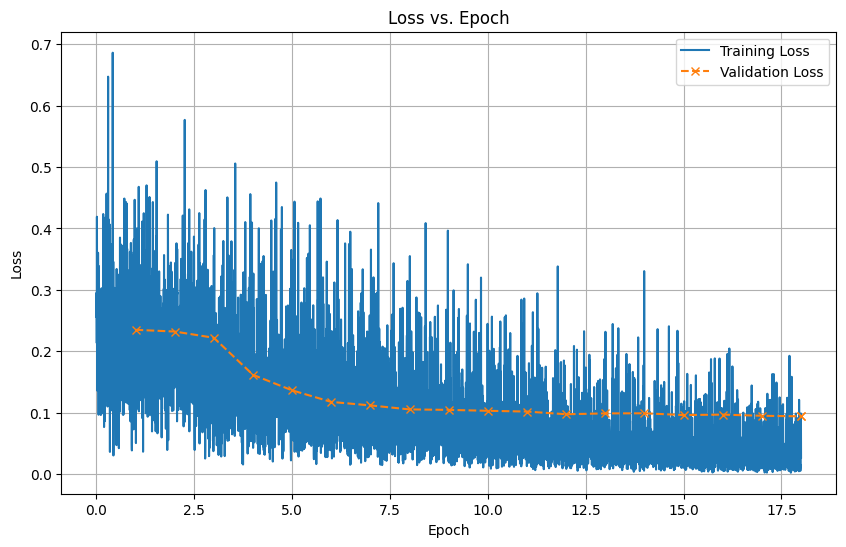

In [86]:
# Extract log history
log_history = trainer.state.log_history

# Extract training loss and epochs
training_loss = [entry["loss"] for entry in log_history if "loss" in entry]
training_epochs = [entry["epoch"] for entry in log_history if "loss" in entry]

# Extract evaluation loss and epochs
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
eval_epochs = [entry["epoch"] for entry in log_history if "eval_loss" in entry]

# Plot training and evaluation loss vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(training_epochs, training_loss, label="Training Loss")
plt.plot(eval_epochs, eval_loss, marker="x", label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()

## 3.9 Validación

Se elige una imagen al azar y se compara con las etiquetas que trae el dataset.
- Flecha Azul: "groundtruth", la mirada que está etiquetada en el dataset.
- Felcha verde: mirada predicha.

In [ ]:
# # Se elige el mejor modelo para validación
# loaded_model = GazeEstimation_MobileNet()
# loaded_model.load_state_dict(torch.load('./modelos/gaze360/mobilenet__epochs_100__lr_1Em4_filtered_yaw.pth'))
# loaded_model.to(device)

# # Sanity check
# inputs = torch.randn(8, 3, 224, 224).to(device) 
# outputs = loaded_model(inputs) 

# print(outputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Tiempo de predicción: 45.11ms 
Actual: 
	 pitch=-0.318 rad | yaw=0.068 rad
	 proyección 2D del ángulo: 257.69° deg
Predicted: 
	 pitch=-0.043 rad | yaw=-0.321 rad
	 proyección 2D del ángulo: 277.71° deg
**Preciso (tolerancia = 15°): 0


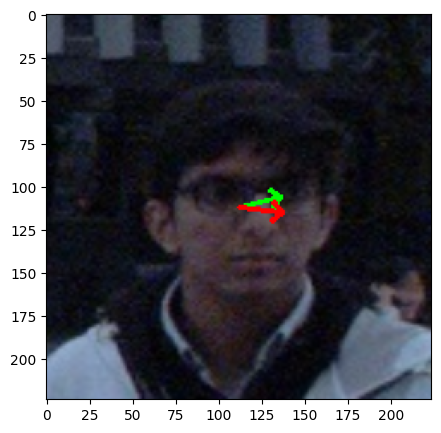

In [90]:
# Pick model
# model = loaded_model

# Randomly select image and its labels
data = ds[randint(0,len(train_dataset)-1)]
img = data["pixel_values"]
gaze = data["labels"]
pitch = data["labels"][0]
yaw = data["labels"][1]
angle = angle_to_2d(np.array([gaze]))

# Get start time
start_time = time.time()

# Run inference and get prediction
predicted_gaze = model(img.unsqueeze(0).to(device))
yaw_predicted = predicted_gaze["predictions"][0][0].item()
pitch_predicted = predicted_gaze["predictions"][0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze["predictions"].squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Get end time
end_time = time.time()

# Print prediction time
prediction_time = end_time - start_time
print(f"Tiempo de predicción: {prediction_time*1000:.2f}ms ")

# Define error tolerance
tolerancia = 15 # 15 degrees
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Print results
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Add annotations
img = draw_gaze360_arrow(img,gaze,"center",scale=80)
img = draw_gaze360_arrow(img,predicted_gaze,"center",color=(255,0,0),scale=80)
# img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0), label="Predicted",label_y=22) #Prediced: green
# img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0),label="Actual",label_y=10) #Actual: blue

# Show images (after converting it from BGR to RGB)
plt.figure(figsize=(5,5))
plt.imshow(img)